In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys, os, time, gzip, pickle, urllib
from PIL import Image

In [2]:
#下载和处理MNIST数据集
#函数名之前带有_的函数都是只会被其他函数调用的。

#data来源
url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
	'train_img':'train-images-idx3-ubyte.gz',
	'train_label':'train-labels-idx1-ubyte.gz',
	'test_img':'t10k-images-idx3-ubyte.gz',
	'test_label':'t10k-labels-idx1-ubyte.gz'
}

#data保存在当前目录，os.getcwd()是执行命令的位置，sys.path[0]是脚本所在的位置
dataset_dir = os.getcwd() + "/MNIST_data"
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

def _download_mnist(): #下载数据到当前目录
	for file_name in key_file.values():
		file_path = dataset_dir + "/" + file_name
		if os.path.exists(file_path): #已经下载了就跳过
			continue
		else :
			print("Downloading " + file_name + " ... ")
			urllib.request.urlretrieve(url_base + file_name, file_path)
			print("Done")

def _load_label(file_name):
	file_path = dataset_dir + "/" + file_name
	print("Converting " + file_name + " to NumPy Array ...")
	with gzip.open(file_path, 'rb') as f:
		labels = np.frombuffer(f.read(), np.uint8, offset=8)
	print("Done")
	return labels

def _load_img(file_name):
	file_path = dataset_dir + "/" + file_name
	print("Converting " + file_name + " to NumPy Array ...")
	with gzip.open(file_path, 'rb') as f:
		data = np.frombuffer(f.read(), np.uint8, offset=16)
	data = data.reshape(-1, img_size)
	print("Done")
	return data

def _convert_numpy(): #加载data到dataset里面
	dataset = {}
	dataset['train_img'] =  _load_img(key_file['train_img'])
	dataset['train_label'] = _load_label(key_file['train_label'])
	dataset['test_img'] = _load_img(key_file['test_img'])
	dataset['test_label'] = _load_label(key_file['test_label'])
	return dataset

def _init_mnist(): #下载,转换，保存data到当前目录的mnist.pkl
	_download_mnist()
	dataset = _convert_numpy()
	print("Creating pickle file ...")
	with open(save_file, 'wb') as f:
		pickle.dump(dataset, f, -1)
	print("Done!")

def _change_one_hot_label(X): #用0,1数组表示label
	T = np.zeros((X.size, 10))
	for idx, row in enumerate(T):
		row[X[idx]] = 1
	return T


def load_mnist(normalize=False, flatten=False, one_hot_label=False):
	"""
	#normalize = Ture 设置图像是否正化到0.0-1.0, 否则像素为0-255
	#flatten = Ture 输出784个元素的一维数组, 否则输出1x28x28的三维数组
	#one_hot_label = Ture label将会是10个元素的1维数组，否则label为0-9数字
	"""
	if not os.path.exists(save_file):
		_init_mnist()

	with open(save_file, 'rb') as f:
		dataset = pickle.load(f)

	if normalize:
		for key in ('train_img', 'test_img'):
			dataset[key] = dataset[key].astype(np.float32)
			dataset[key] /= 255.0

	if one_hot_label:
		dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
		dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

	if not flatten:
		for key in ('train_img', 'test_img'):
			dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

	return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


class MNIST:
	def __init__(self, batch_size = 50):
		(self.train_image, self.train_label), (self.test_image, self.test_label) = load_mnist(normalize=True, flatten=True, one_hot_label=True)
		self.train_len = len(self.train_image)
		self.test_len = len(self.test_image)
		self.batch_size = batch_size
		self.batch_number = 0

	def batch(self):
		temp_image = []
		temp_label = []
		for i in range(self.batch_size):
			temp = (self.batch_number * self.batch_size + i) % self.train_len
			temp_image.append(self.train_image[temp])
			temp_label.append(self.train_label[temp])
		self.batch_number += 1
		return temp_image, temp_label


In [3]:
# model 1
# 全连接神经网络ANN, 一次性输入全部训练数据

(train_image, train_label), (test_image, test_label) = load_mnist(normalize=True, flatten=True, one_hot_label=True)

tabel1 = {'time':[], 'accuracy':[], 'cost':[], 'prediction': []}
literations = 60
time_period = 10
alpha = 1e-5

#tensorflow: define placeholder
image_placeholder = tf.placeholder(tf.float32, [None, 784])
label_placeholder = tf.placeholder(tf.float32, [None, 10])

#tendorflow: Fully Connected Layer
weight_fc_1 = tf.Variable(tf.ones([784, 10]))
bias_fc_1 = tf.Variable(tf.ones([10]))
fc_1 = tf.matmul(image_placeholder, weight_fc_1) + bias_fc_1
prediction_label = tf.nn.softmax(fc_1)

#tendorflow: minimize cost function: cross_entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(label_placeholder * tf.log(prediction_label + 1e-7)))
train_step = tf.train.GradientDescentOptimizer(alpha).minimize(cross_entropy)

#预测精确率
correct_prediction = tf.equal(tf.argmax(prediction_label, 1), tf.argmax(label_placeholder, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#初始化
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


#start training
print("start training...")
start_time = time.clock()
end_time = time.clock()
for i in range(literations):
    while end_time - start_time < time_period:
        sess.run(train_step, feed_dict={image_placeholder: train_image, label_placeholder: train_label})
        end_time = time.clock()
    cost = sess.run(cross_entropy, feed_dict={image_placeholder: train_image, label_placeholder: train_label})
    acc = sess.run(accuracy, feed_dict={image_placeholder: test_image, label_placeholder: test_label})
    tabel1['time'].append((i+1)*time_period)
    tabel1['accuracy'].append(acc)
    tabel1['cost'].append(cost)
    print("Time: %d seconds, Accuracy: %f, Cost: %f" %(tabel1['time'][i], tabel1['accuracy'][i], tabel1['cost'][i]))
    start_time = time.clock()
    end_time = time.clock()

tabel1['prediction'] = sess.run(correct_prediction, feed_dict={image_placeholder: test_image, label_placeholder: test_label})

#close session
sess.close()

Instructions for updating:
Colocations handled automatically by placer.
start training...
Time: 10 seconds, Accuracy: 0.888900, Cost: 27786.242188
Time: 20 seconds, Accuracy: 0.903000, Cost: 23092.537109
Time: 30 seconds, Accuracy: 0.908400, Cost: 21307.082031
Time: 40 seconds, Accuracy: 0.911800, Cost: 20273.265625
Time: 50 seconds, Accuracy: 0.914400, Cost: 19595.074219
Time: 60 seconds, Accuracy: 0.915700, Cost: 19106.003906
Time: 70 seconds, Accuracy: 0.917400, Cost: 18711.933594
Time: 80 seconds, Accuracy: 0.918200, Cost: 18406.494141
Time: 90 seconds, Accuracy: 0.918900, Cost: 18161.566406
Time: 100 seconds, Accuracy: 0.919400, Cost: 17940.367188
Time: 110 seconds, Accuracy: 0.919700, Cost: 17749.763672
Time: 120 seconds, Accuracy: 0.919900, Cost: 17583.134766
Time: 130 seconds, Accuracy: 0.919600, Cost: 17435.699219
Time: 140 seconds, Accuracy: 0.920400, Cost: 17306.322266
Time: 150 seconds, Accuracy: 0.921000, Cost: 17200.425781
Time: 160 seconds, Accuracy: 0.921200, Cost: 1710

In [4]:
# model 2
# 循环神经网络RNN

mnist = MNIST()
tabel2 = {'time':[], 'accuracy':[], 'cost':[], 'prediction': []}
literations = 60
time_period = 10
alpha = 1e-3

#tensorflow: define placeholder
image_placeholder = tf.placeholder(tf.float32, [None, 784])
label_placeholder = tf.placeholder(tf.float32, [None, 10])


x_image = tf.reshape(image_placeholder, [-1, 28, 28])
sequence = tf.unstack(tf.transpose(x_image, [1, 0, 2]))

#weight and bias for RNN outputs
weight = tf.Variable(tf.ones([28, 10]))
bias = tf.Variable(tf.ones([10]))

#定义RNN, 用LSTM结构
lstm = tf.nn.rnn_cell.LSTMCell(28, name = 'rnn')
outputs, state = tf.nn.static_rnn(lstm, sequence, dtype=tf.float32)

#仅仅关心最后一步的输出，取outputs[-1]就可以
logits = tf.matmul(outputs[-1], weight) + bias

#tendorflow: minimize cost function: cross_entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=label_placeholder))
train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)

#预测精确率
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label_placeholder, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#初始化
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#start training
print("start training...")
start_time = time.clock()
end_time = time.clock()
for i in range(literations):
    while end_time - start_time < time_period:
        batch_image, batch_label = mnist.batch()
        sess.run(train_step, feed_dict={image_placeholder: batch_image, label_placeholder: batch_label})
        end_time = time.clock()
    cost = sess.run(cross_entropy, feed_dict={image_placeholder: batch_image, label_placeholder: batch_label})
    acc = sess.run(accuracy, feed_dict={image_placeholder: mnist.test_image, label_placeholder: mnist.test_label})
    tabel2['time'].append((i+1)*time_period)
    tabel2['accuracy'].append(acc)
    tabel2['cost'].append(cost)
    print("Time: %d seconds, Accuracy: %f, Cost: %f" %(tabel2['time'][i], tabel2['accuracy'][i], tabel2['cost'][i]))
    start_time = time.clock()
    end_time = time.clock()

tabel2['prediction'] = sess.run(correct_prediction, feed_dict={image_placeholder: test_image, label_placeholder: test_label})

#close session
sess.close()

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

start training...
Time: 10 seconds, Accuracy: 0.861900, Cost: 0.373226
Time: 20 seconds, Accuracy: 0.918200, Cost: 0.154052
Time: 30 seconds, Accuracy: 0.944500, Cost: 0.126476
Time: 40 seconds, Accuracy: 0.949400, Cost: 0.286527
Time: 50 seconds, Accuracy: 0.962200, Cost: 0.061339
Time: 60 seconds, Accuracy: 0.960900, Cost: 0.053561
Time: 70 seconds, Accuracy: 0.962000, Cost: 0.214412
Time: 80 seconds, Accuracy: 0.968200, Cost: 0.029877
Time: 90 seconds, Accuracy: 0.972300, Cost: 0.082767
Time: 100 seconds, Accuracy: 0.969200, Cost: 0.024443
Time: 110 seconds, Acc

In [5]:
# model 3
# 卷积接神经网络CNN

mnist = MNIST()
tabel3 = {'time':[], 'accuracy':[], 'cost':[], 'prediction': []}
literations = 60
time_period = 10
alpha = 1e-4

def weight_variable(shape):
	initial = tf.truncated_normal(shape, stddev=0.1)
	return tf.Variable(initial)

def bias_variable(shape):
	initial = tf.constant(0.1, shape=shape)
	return tf.Variable(initial)

def conv2d(x, W):
	return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


#tensorflow: define placeholder
image_placeholder = tf.placeholder(tf.float32, [None, 784])
label_placeholder = tf.placeholder(tf.float32, [None, 10])

# 将单张图片从784维向量重新还原为28x28的矩阵图片
x_image = tf.reshape(image_placeholder, [-1, 28, 28, 1])

# 第一层卷积+池化层
weight_conv_1 = weight_variable([5, 5, 1, 32])
bias_conv_1 = bias_variable([32])
h_conv_1 = tf.nn.relu(conv2d(x_image, weight_conv_1) + bias_conv_1)
h_pool_1 = max_pool_2x2(h_conv_1)  #shape:(batch_size, 14, 14, 32)

# 第二层卷积+池化层
weight_conv_2 = weight_variable([5, 5, 32, 64])
bias_conv_2 = bias_variable([64])
h_conv_2 = tf.nn.relu(conv2d(h_pool_1, weight_conv_2) + bias_conv_2)
h_pool_2 = max_pool_2x2(h_conv_2)  #shape:(batch_size, 7, 7, 64)

# 全连接层，输出为1024维的向量
weight_fc1 = weight_variable([7 * 7 * 64, 1024])
bias_fc1 = bias_variable([1024])
h_pool_2_flat = tf.reshape(h_pool_2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool_2_flat, weight_fc1) + bias_fc1)

# 把1024维的向量转换成10维，对应10个类别
weight_fc2 = weight_variable([1024, 10])
bias_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1, weight_fc2) + bias_fc2

# Cost: cross_entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label_placeholder, logits=y_conv))
train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)

# 定义测试的准确率
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(label_placeholder, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 创建Session和变量初始化
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#start training
print("start training...")
start_time = time.clock()
end_time = time.clock()
for i in range(literations):
    while end_time - start_time < time_period:
        batch_image, batch_label = mnist.batch()
        sess.run(train_step, feed_dict={image_placeholder: batch_image, label_placeholder: batch_label})
        end_time = time.clock()
    cost = sess.run(cross_entropy, feed_dict={image_placeholder: batch_image, label_placeholder: batch_label})
    #acc = sess.run(accuracy, feed_dict={image_placeholder: mnist.test_image, label_placeholder: mnist.test_label})
    acc = sess.run(accuracy, feed_dict={image_placeholder: mnist.test_image, label_placeholder: mnist.test_label})
    tabel3['time'].append((i+1)*time_period)
    tabel3['accuracy'].append(acc)
    tabel3['cost'].append(cost)
    print("Time: %d seconds, Accuracy: %f, Cost: %f" %(tabel3['time'][i], tabel3['accuracy'][i], tabel3['cost'][i]))
    start_time = time.clock()
    end_time = time.clock()

tabel3['prediction'] = sess.run(correct_prediction, feed_dict={image_placeholder: test_image, label_placeholder: test_label})

#习惯性close session
sess.close()

start training...
Time: 10 seconds, Accuracy: 0.777400, Cost: 0.607990
Time: 20 seconds, Accuracy: 0.852300, Cost: 0.276043
Time: 30 seconds, Accuracy: 0.841900, Cost: 0.262691
Time: 40 seconds, Accuracy: 0.903000, Cost: 0.260478
Time: 50 seconds, Accuracy: 0.927300, Cost: 0.312321
Time: 60 seconds, Accuracy: 0.916900, Cost: 0.249936
Time: 70 seconds, Accuracy: 0.933400, Cost: 0.289467
Time: 80 seconds, Accuracy: 0.928400, Cost: 0.367905
Time: 90 seconds, Accuracy: 0.936900, Cost: 0.141164
Time: 100 seconds, Accuracy: 0.937500, Cost: 0.046117
Time: 110 seconds, Accuracy: 0.945900, Cost: 0.112973
Time: 120 seconds, Accuracy: 0.958600, Cost: 0.067661
Time: 130 seconds, Accuracy: 0.947400, Cost: 0.258048
Time: 140 seconds, Accuracy: 0.952400, Cost: 0.244083
Time: 150 seconds, Accuracy: 0.951600, Cost: 0.244726
Time: 160 seconds, Accuracy: 0.965900, Cost: 0.049328
Time: 170 seconds, Accuracy: 0.963200, Cost: 0.057882
Time: 180 seconds, Accuracy: 0.966500, Cost: 0.148761
Time: 190 seconds, 

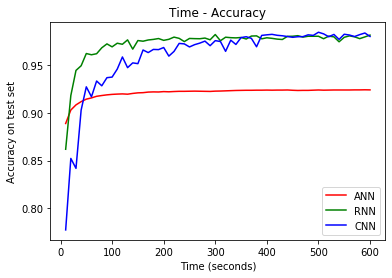

                               图3.1


In [45]:
plt.title("Time - Accuracy")
plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy on test set")
plt.plot(tabel1['time'], tabel1['accuracy'], label = 'ANN', color = 'red')
plt.plot(tabel2['time'], tabel2['accuracy'], label = 'RNN', color = 'green')
plt.plot(tabel3['time'], tabel3['accuracy'], label = 'CNN', color = 'blue')
plt.legend(loc='best')
plt.show()
print("                               图3.1")

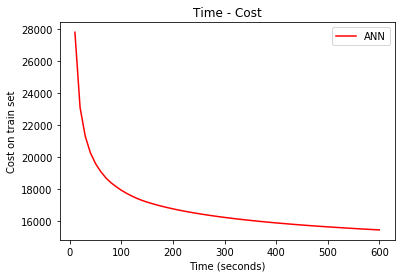

                        图3.2


In [46]:
plt.title("Time - Cost")
plt.xlabel("Time (seconds)")
plt.ylabel("Cost on train set")
plt.plot(tabel1['time'], tabel1['cost'], label = 'ANN', color = 'red')
plt.legend(loc='best')
plt.show()
print("                        图3.2")

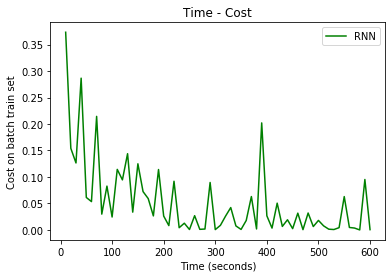

                        图3.3


In [47]:
plt.title("Time - Cost")
plt.xlabel("Time (seconds)")
plt.ylabel("Cost on batch train set")
plt.plot(tabel2['time'], tabel2['cost'], label = 'RNN', color = 'green')
plt.legend(loc='best')
plt.show()
print("                        图3.3")

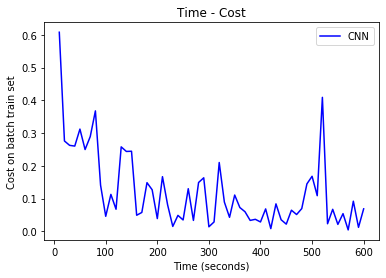

                        图3.4


In [48]:
plt.title("Time - Cost")
plt.xlabel("Time (seconds)")
plt.ylabel("Cost on batch train set")
plt.plot(tabel3['time'], tabel3['cost'], label = 'CNN', color = 'blue')
plt.legend(loc='best')
plt.show()
print("                        图3.4")